# Draft Pipeline
#### For some some reason, I am not seeing the thinnest thicknesses for every slice allign with where the actual location should be in the enface image.
#### What I think might make this pipeline work: it might be helpful to collect the top 10 lowest points for every b-scan, along with their fovea index (the fovea x-position in the b-scan) and see how these points look when plotted on an enface image. In this way, the biggest cluster might meaningfully coincide with where the fovea is located.

In [2]:
import numpy as np
import cv2
import os
from scipy import ndimage
from skimage.restoration import denoise_nl_means, estimate_sigma

# ======= Load and Preprocess Image =======
def load_oct_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Failed to load image from {image_path}")
    return image

def preprocess_oct_image(image):
    sigma_est = np.mean(estimate_sigma(image))
    denoised_image = denoise_nl_means(image, h=1.15 * sigma_est, fast_mode=True, patch_size=5, patch_distance=6)
    denoised_image = (denoised_image * 255).astype(np.uint8)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced_image = clahe.apply(denoised_image)
    
    return enhanced_image

# ======= Locate Retina Region =======
def locate_retina_region(image):
    row_means = np.mean(image, axis=1)
    threshold = np.mean(row_means) + 0.5 * np.std(row_means)
    high_intensity_rows = np.where(row_means > threshold)[0]
    
    if len(high_intensity_rows) > 0:
        top_row = max(0, np.min(high_intensity_rows) - 20)
        bottom_row = min(image.shape[0] - 1, np.max(high_intensity_rows) + 20)
    else:
        top_row, bottom_row = int(image.shape[0] * 0.3), int(image.shape[0] * 0.7)
    
    return top_row, bottom_row

# ======= Segment ILM & RNFL Layers =======
def segment_retinal_layers(image):
    top_row, bottom_row = locate_retina_region(image)
    retina_region = image[top_row:bottom_row, :]
    
    gradient_y = cv2.Sobel(retina_region, cv2.CV_64F, 0, 1, ksize=3)
    _, binary = cv2.threshold(retina_region, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    ilm_line = np.zeros(image.shape[1], dtype=int)
    rnfl_line = np.zeros(image.shape[1], dtype=int)

    for x in range(image.shape[1]):
        column = binary[:, x]
        white_pixels = np.where(column > 0)[0]
        
        if len(white_pixels) > 0:
            ilm_idx = white_pixels[0]
            ilm_line[x] = top_row + ilm_idx
            search_start = min(ilm_idx + 5, len(gradient_y[:, x]) - 1)
            search_end = min(ilm_idx + 50, len(gradient_y[:, x]) - 1)
            
            if search_start < search_end:
                subregion = gradient_y[:, x][search_start:search_end]
                rnfl_idx = search_start + np.argmin(subregion)
                rnfl_line[x] = top_row + rnfl_idx
            else:
                rnfl_line[x] = ilm_line[x] + 5
        else:
            ilm_line[x] = ilm_line[x-1] if x > 0 else top_row
            rnfl_line[x] = rnfl_line[x-1] if x > 0 else top_row + 10

    ilm_line = ndimage.median_filter(ilm_line, size=11)
    rnfl_line = ndimage.median_filter(rnfl_line, size=11)
    
    for x in range(image.shape[1]):
        if rnfl_line[x] < ilm_line[x] + 3:
            rnfl_line[x] = ilm_line[x] + 3
    
    return ilm_line, rnfl_line

# ======= Compute RNFL Thickness =======
def compute_rnfl_thickness(ilm_line, rnfl_line):
    return rnfl_line - ilm_line

# ======= Detect Fovea Position =======
def detect_nfd_fovea(thickness):
    min_thickness = np.min(thickness)
    near_zero_thickness = (thickness <= min(min_thickness + 2, 3))
    
    if np.any(near_zero_thickness):
        labeled_regions, num_regions = ndimage.label(near_zero_thickness)
        region_properties = [
            {
                'id': region_id,
                'center': int(np.mean(np.where(labeled_regions == region_id)[0])),
                'size': len(np.where(labeled_regions == region_id)[0]),
                'dist_from_center': abs(int(np.mean(np.where(labeled_regions == region_id)[0])) - len(thickness) // 2)
            }
            for region_id in range(1, num_regions + 1)
        ]
        region_properties.sort(key=lambda x: (x['dist_from_center'], -x['size']))
        fovea_position = region_properties[0]['center']
    else:
        smoothed_thickness = ndimage.gaussian_filter1d(thickness, sigma=5)
        min_indices = [(i, smoothed_thickness[i]) for i in range(1, len(smoothed_thickness) - 1)
                       if smoothed_thickness[i] < smoothed_thickness[i-1] and smoothed_thickness[i] < smoothed_thickness[i+1]]
        
        if min_indices:
            center = len(thickness) // 2
            min_indices.sort(key=lambda x: (x[1], abs(x[0] - center)))
            fovea_position = min_indices[0][0]
        else:
            fovea_position = np.argmin(smoothed_thickness)
    
    return fovea_position, thickness[fovea_position]

# ======= Process a Single Image =======
def process_image(image_path):
    try:
        image = load_oct_image(image_path)
        preprocessed_image = preprocess_oct_image(image)
        ilm_line, rnfl_line = segment_retinal_layers(preprocessed_image)
        thickness = compute_rnfl_thickness(ilm_line, rnfl_line)
        fovea_position, fovea_thickness = detect_nfd_fovea(thickness)

        return fovea_position, fovea_thickness
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

# ======= Process All Images in Folder =======
def process_all_images(image_folder):
    results = {}
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.tif'))]
    
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        print(f"Processing {image_file}...")
        fovea_position, fovea_thickness = process_image(image_path)

        if fovea_position is not None:
            results[image_file] = {
                "fovea_position": fovea_position,
                "fovea_thickness": fovea_thickness
            }
        else:
            print(f"Skipping {image_file}, no fovea detected.")

    return results

# ======= Main Function =======
if __name__ == "__main__":
    img_folder = r"C:\Users\micah\OneDrive\Gmail OneDrive\Desktop\CMU\_Spring 2025\Projects in BME\Fovea Detection\ORG_IMG_JPG_2"
    
    print("Starting fovea detection pipeline...")
    results = process_all_images(img_folder)
    
    print("\nFinal Results:")
    for img, data in results.items():
        print(f"{img}: Fovea Position = {data['fovea_position']}, Thickness = {data['fovea_thickness']}")



Starting fovea detection pipeline...
Processing 40003229_20210615_141500_R_OCT_512x1024x128_ORG_IMG_JPG_0001.jpg...
Processing 40003229_20210615_141500_R_OCT_512x1024x128_ORG_IMG_JPG_0002.jpg...
Processing 40003229_20210615_141500_R_OCT_512x1024x128_ORG_IMG_JPG_0003.jpg...
Processing 40003229_20210615_141500_R_OCT_512x1024x128_ORG_IMG_JPG_0004.jpg...
Processing 40003229_20210615_141500_R_OCT_512x1024x128_ORG_IMG_JPG_0005.jpg...
Processing 40003229_20210615_141500_R_OCT_512x1024x128_ORG_IMG_JPG_0006.jpg...
Processing 40003229_20210615_141500_R_OCT_512x1024x128_ORG_IMG_JPG_0007.jpg...
Processing 40003229_20210615_141500_R_OCT_512x1024x128_ORG_IMG_JPG_0008.jpg...
Processing 40003229_20210615_141500_R_OCT_512x1024x128_ORG_IMG_JPG_0009.jpg...
Processing 40003229_20210615_141500_R_OCT_512x1024x128_ORG_IMG_JPG_0010.jpg...
Processing 40003229_20210615_141500_R_OCT_512x1024x128_ORG_IMG_JPG_0011.jpg...
Processing 40003229_20210615_141500_R_OCT_512x1024x128_ORG_IMG_JPG_0012.jpg...
Processing 4000

In [3]:
# print(results.values())
print([value['fovea_thickness'] for value in results.values()])


[np.int64(5), np.int64(10), np.int64(22), np.int64(8), np.int64(10), np.int64(11), np.int64(7), np.int64(15), np.int64(6), np.int64(11), np.int64(5), np.int64(5), np.int64(25), np.int64(13), np.int64(11), np.int64(12), np.int64(10), np.int64(11), np.int64(5), np.int64(9), np.int64(18), np.int64(12), np.int64(8), np.int64(6), np.int64(5), np.int64(11), np.int64(29), np.int64(8), np.int64(12), np.int64(12), np.int64(8), np.int64(15), np.int64(14), np.int64(7), np.int64(17), np.int64(6), np.int64(19), np.int64(7), np.int64(15), np.int64(13), np.int64(14), np.int64(18), np.int64(30), np.int64(15), np.int64(7), np.int64(12), np.int64(19), np.int64(10), np.int64(13), np.int64(6), np.int64(16), np.int64(15), np.int64(12), np.int64(13), np.int64(10), np.int64(5), np.int64(9), np.int64(7), np.int64(10), np.int64(8), np.int64(10), np.int64(12), np.int64(11), np.int64(7), np.int64(11), np.int64(10), np.int64(11), np.int64(12), np.int64(7), np.int64(10), np.int64(6), np.int64(11), np.int64(9), np.

Probable fovea detected at index: 107 (thickness: 3)


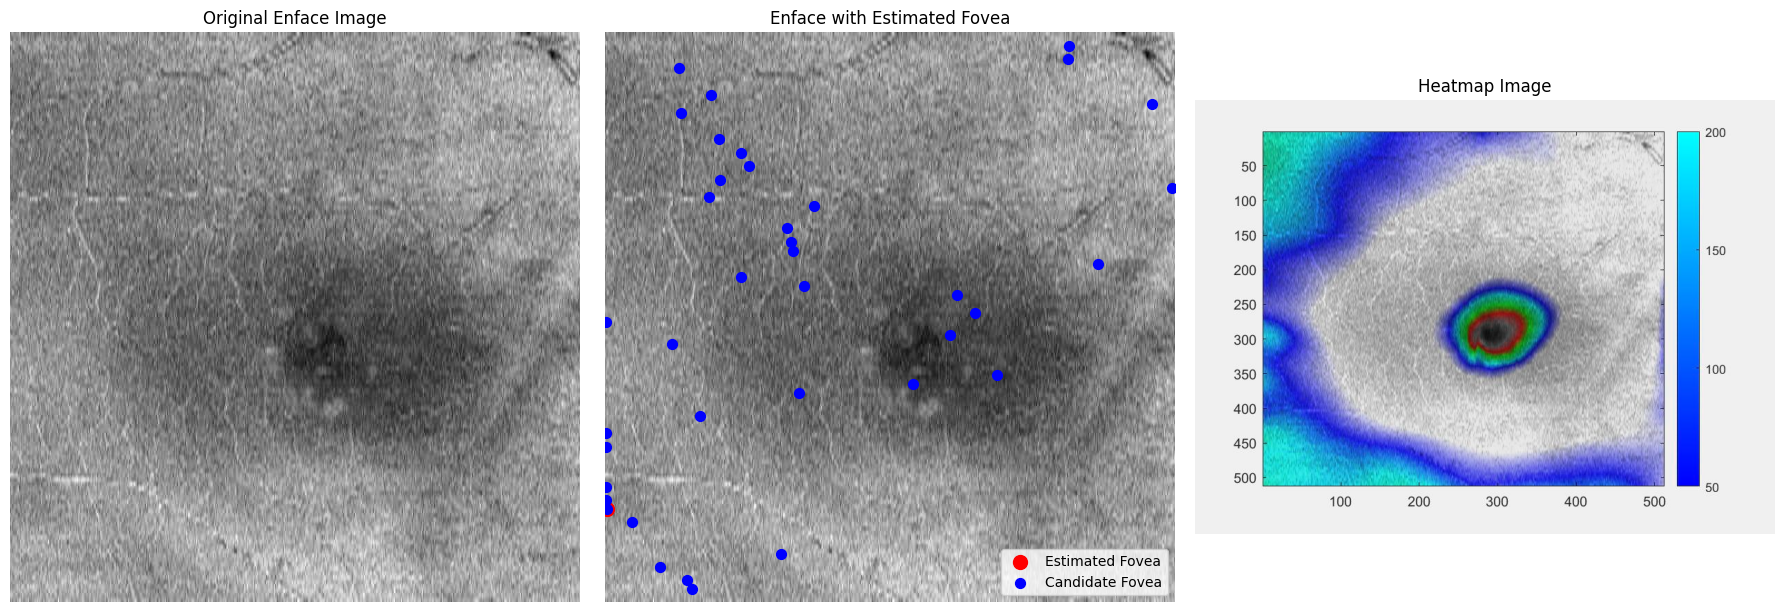

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import argrelextrema

def find_probable_fovea_location(fovea_thicknesses):
    """
    Identify the most probable fovea location based on local minimums in retinal thickness.

    Args:
        fovea_thicknesses (list): A list of fovea thickness values across slices.

    Returns:
        int: Index of the most probable fovea location.
    """
    fovea_thicknesses = np.array(fovea_thicknesses)

    # Step 1: Find all local minimum indices
    local_minima = argrelextrema(fovea_thicknesses, np.less)[0]

    if len(local_minima) == 0:
        print("No local minima found, defaulting to global minimum.")
        return int(np.argmin(fovea_thicknesses))  # Return absolute minimum if no local minima

    # Step 2: Find the deepest local minimum (smallest thickness)
    min_thickness_values = fovea_thicknesses[local_minima]
    min_thickness_idx = local_minima[np.argmin(min_thickness_values)]

    # Step 3: If multiple deep local minima exist, choose one closest to center
    center_index = len(fovea_thicknesses) // 2
    min_thickness_candidates = local_minima[min_thickness_values == np.min(min_thickness_values)]
    probable_fovea_index = min(min_thickness_candidates, key=lambda x: abs(x - center_index))

    print(f"Probable fovea detected at index: {probable_fovea_index} (thickness: {fovea_thicknesses[probable_fovea_index]})")
    return probable_fovea_index

def plot_enface_with_fovea(enface_image_path, heatmap_path, results):
    """
    Plot the original enface image, enface image with fovea locations, and heatmap side by side.

    Args:
        enface_image_path (str): Path to the enface image.
        heatmap_path (str): Path to the heatmap image.
        results (dict): Dictionary containing 'fovea_position' and 'fovea_thickness' per slice.
    """
    # Extract fovea thickness values
    fovea_thicknesses = [value['fovea_thickness'] for value in results.values()]
    probable_fovea_index = find_probable_fovea_location(fovea_thicknesses)

    # Extract the estimated fovea position from results
    fovea_position = list(results.values())[probable_fovea_index]['fovea_position']
    
    # Scale fovea position to enface image
    scaled_fovea = (fovea_position, probable_fovea_index * 4)  # Multiply Y by 4

    # Candidate foveas: all local minima locations
    local_minima = argrelextrema(np.array(fovea_thicknesses), np.less)[0]
    candidate_foveas = [(list(results.values())[idx]['fovea_position'], idx * 4) for idx in local_minima]

    # Load images
    enface_image = cv2.imread(enface_image_path, cv2.IMREAD_GRAYSCALE)
    heatmap_image = cv2.imread(heatmap_path)  # Keep original colors

    if enface_image is None or heatmap_image is None:
        raise ValueError("Failed to load one or more images.")

    # Create figure with (1, 3) subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # ---- Subplot 1: Original Enface Image ----
    axs[0].imshow(enface_image, cmap='gray')
    axs[0].set_title("Original Enface Image")
    axs[0].axis("off")

    # ---- Subplot 2: Enface Image with Fovea Locations ----
    axs[1].imshow(enface_image, cmap='gray')
    axs[1].set_title("Enface with Estimated Fovea")
    axs[1].scatter(scaled_fovea[0], scaled_fovea[1], color='red', s=100, label='Estimated Fovea')

    # Plot candidate foveas
    for candidate in candidate_foveas:
        axs[1].scatter(candidate[0], candidate[1], color='blue', s=50, label='Candidate Fovea' if candidate == candidate_foveas[0] else "")

    axs[1].legend()
    axs[1].axis("off")

    # ---- Subplot 3: Heatmap Image ----
    axs[2].imshow(heatmap_image)  # Original colors
    axs[2].set_title("Heatmap Image")
    axs[2].axis("off")

    # Show plot
    plt.tight_layout()
    plt.show()

# Example Usage
enface_image_path = 'og_enface2.jpg'
heatmap_path = 'heatmap2.jpg'
plot_enface_with_fovea(enface_image_path, heatmap_path, results)


Probable fovea detected at index: 107 (thickness: 3)


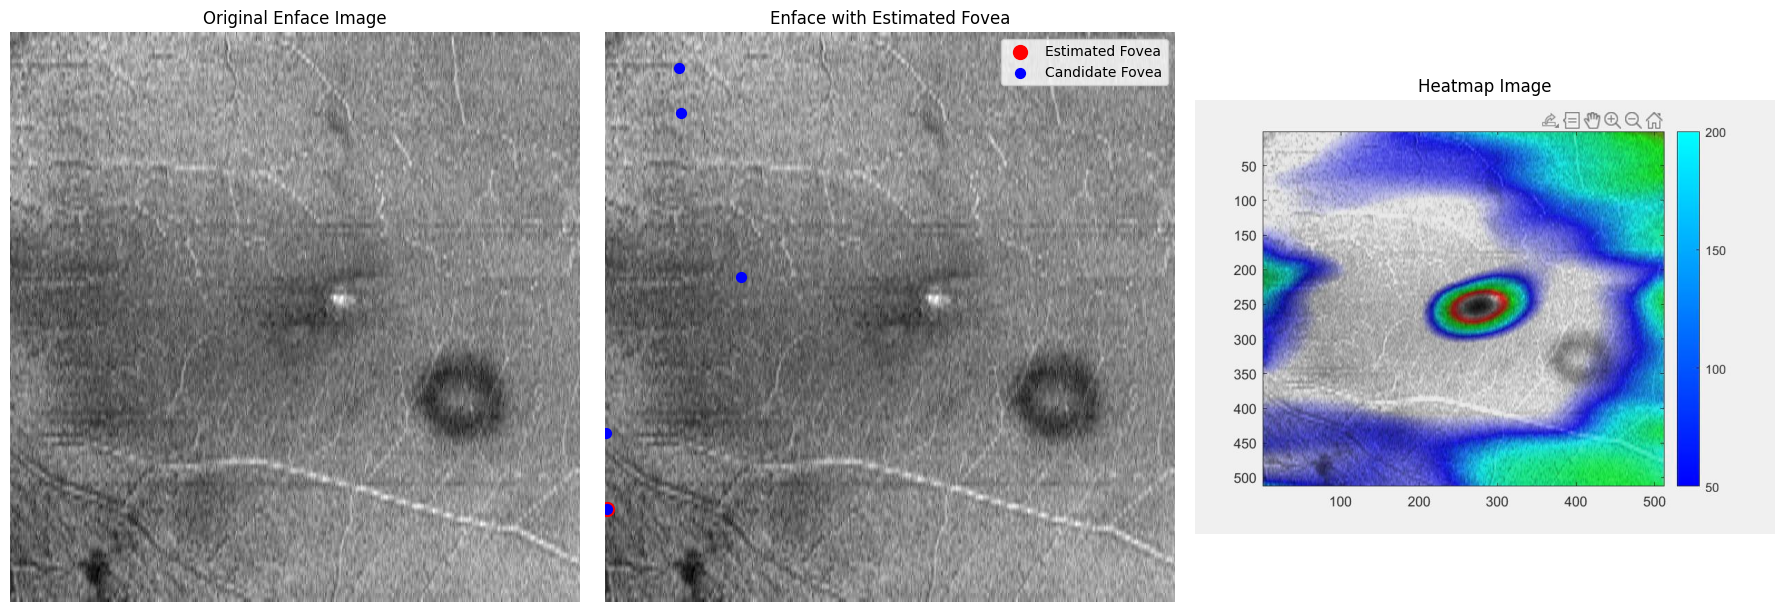

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

def find_probable_fovea_location(fovea_thicknesses):
    """
    Identify the most probable fovea location based on local minimums in retinal thickness.

    Args:
        fovea_thicknesses (list): A list of fovea thickness values across slices.

    Returns:
        int: Index of the most probable fovea location.
    """
    fovea_thicknesses = np.array(fovea_thicknesses)

    # Step 1: Find all local minima indices
    local_minima = argrelextrema(fovea_thicknesses, np.less)[0]

    if len(local_minima) == 0:
        print("No local minima found, defaulting to global minimum.")
        return int(np.argmin(fovea_thicknesses))  # Return absolute minimum if no local minima

    # Step 2: Find the deepest local minimum (smallest thickness)
    min_thickness_values = fovea_thicknesses[local_minima]
    min_thickness_idx = local_minima[np.argmin(min_thickness_values)]

    # Step 3: If multiple deep local minima exist, choose the one closest to the center
    center_index = len(fovea_thicknesses) // 2
    min_thickness_candidates = local_minima[min_thickness_values == np.min(min_thickness_values)]
    probable_fovea_index = min(min_thickness_candidates, key=lambda x: abs(x - center_index))

    print(f"Probable fovea detected at index: {probable_fovea_index} (thickness: {fovea_thicknesses[probable_fovea_index]})")
    return probable_fovea_index, local_minima

def filter_candidate_foveas(fovea_thicknesses, local_minima, max_candidates=5, min_spacing=8):
    """
    Reduce the number of candidate fovea locations by selecting only strong, well-spaced minima.

    Args:
        fovea_thicknesses (array): Array of fovea thickness values.
        local_minima (array): Indices of local minima.
        max_candidates (int): Maximum number of candidates to keep.
        min_spacing (int): Minimum spacing between candidates to avoid clustering.

    Returns:
        list of int: Filtered candidate indices.
    """
    if len(local_minima) == 0:
        return []

    # Sort local minima by lowest thickness first
    sorted_minima = sorted(local_minima, key=lambda x: fovea_thicknesses[x])

    # Select top `max_candidates`, ensuring spacing between them
    selected_candidates = []
    for idx in sorted_minima:
        if not selected_candidates or all(abs(idx - c) > min_spacing for c in selected_candidates):
            selected_candidates.append(idx)
        if len(selected_candidates) >= max_candidates:
            break

    return selected_candidates

def plot_enface_with_fovea(enface_image_path, heatmap_path, results):
    """
    Plot the original enface image, enface image with fovea locations, and heatmap side by side.

    Args:
        enface_image_path (str): Path to the enface image.
        heatmap_path (str): Path to the heatmap image.
        results (dict): Dictionary containing 'fovea_position' and 'fovea_thickness' per slice.
    """
    # Extract fovea thickness values
    fovea_thicknesses = [value['fovea_thickness'] for value in results.values()]
    probable_fovea_index, local_minima = find_probable_fovea_location(fovea_thicknesses)

    # Filter candidate foveas to reduce excessive dots
    selected_candidates = filter_candidate_foveas(fovea_thicknesses, local_minima)

    # Extract the estimated fovea position from results
    fovea_position = list(results.values())[probable_fovea_index]['fovea_position']

    # Scale fovea position to enface image
    scaled_fovea = (fovea_position, probable_fovea_index * 4)  # Multiply Y by 4

    # Candidate foveas: only the **filtered** local minima
    candidate_foveas = [(list(results.values())[idx]['fovea_position'], idx * 4) for idx in selected_candidates]

    # Load images
    enface_image = cv2.imread(enface_image_path, cv2.IMREAD_GRAYSCALE)
    heatmap_image = cv2.imread(heatmap_path)  # Keep original colors

    if enface_image is None or heatmap_image is None:
        raise ValueError("Failed to load one or more images.")

    # Create figure with (1, 3) subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # ---- Subplot 1: Original Enface Image ----
    axs[0].imshow(enface_image, cmap='gray')
    axs[0].set_title("Original Enface Image")
    axs[0].axis("off")

    # ---- Subplot 2: Enface Image with Fovea Locations ----
    axs[1].imshow(enface_image, cmap='gray')
    axs[1].set_title("Enface with Estimated Fovea")
    axs[1].scatter(scaled_fovea[0], scaled_fovea[1], color='red', s=100, label='Estimated Fovea')

    # Plot candidate foveas (filtered)
    for candidate in candidate_foveas:
        axs[1].scatter(candidate[0], candidate[1], color='blue', s=50, label='Candidate Fovea' if candidate == candidate_foveas[0] else "")

    axs[1].legend()
    axs[1].axis("off")

    # ---- Subplot 3: Heatmap Image ----
    axs[2].imshow(heatmap_image)  # Original colors
    axs[2].set_title("Heatmap Image")
    axs[2].axis("off")

    # Show plot
    plt.tight_layout()
    plt.show()

# Example Usage
enface_image_path = 'og_enface.jpg'
heatmap_path = 'heatmap.jpg'
plot_enface_with_fovea(enface_image_path, heatmap_path, results)


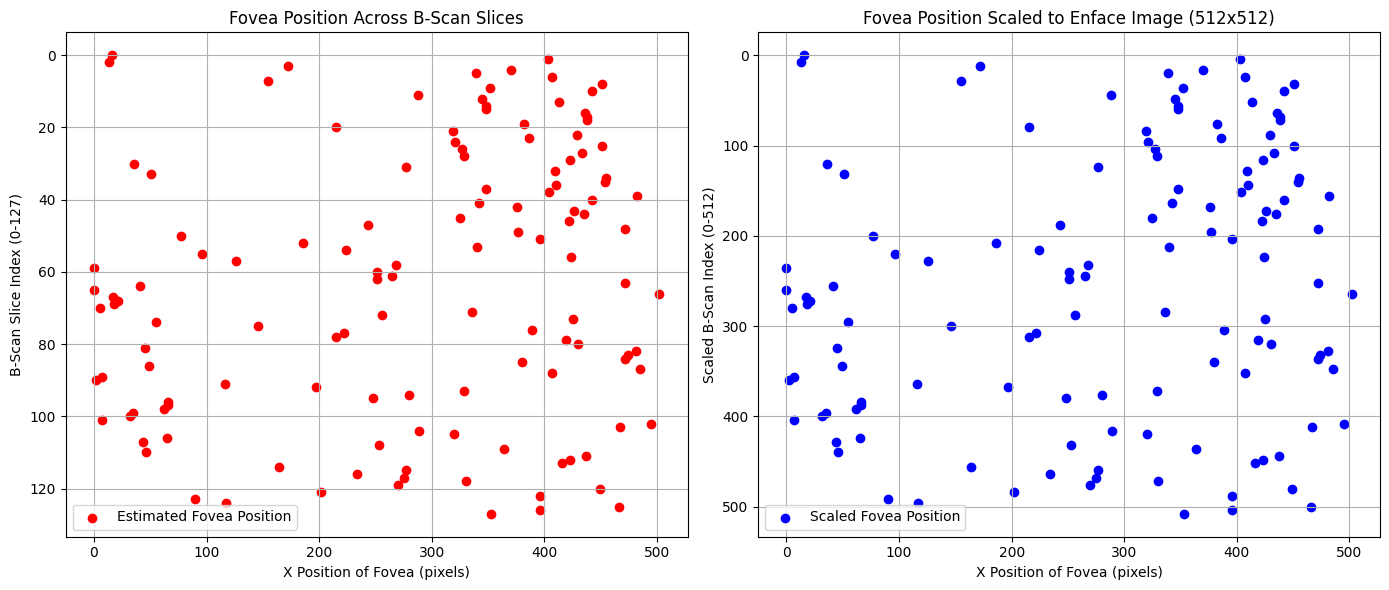

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fovea_across_slices_scaled(results):
    """
    Plot the estimated fovea position for every B-scan slice in both original and scaled formats.
    
    Args:
        results (dict): Dictionary containing 'fovea_position' per slice.
    """
    # Extract slice indices and fovea positions
    slice_indices = np.arange(len(results))  # Slice index (0 to N-1)
    fovea_positions = [value['fovea_position'] for value in results.values()]  # X-coordinates of fovea

    # Scale the Y-dimension (slice index) to match the 512 x 512 enface image
    scaled_slice_indices = slice_indices * 4  # Scale to match enface resolution

    # Create subplots: (1, 2)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # ---- Left Plot: Fovea Positions in Original B-Scan Scale ----
    axs[0].scatter(fovea_positions, slice_indices, color='red', label='Estimated Fovea Position')
    axs[0].invert_yaxis()  # Invert Y-axis for OCT convention
    axs[0].set_title("Fovea Position Across B-Scan Slices")
    axs[0].set_xlabel("X Position of Fovea (pixels)")
    axs[0].set_ylabel("B-Scan Slice Index (0-127)")
    axs[0].legend()
    axs[0].grid(True)

    # ---- Right Plot: Fovea Positions Scaled to 512x512 Enface ----
    axs[1].scatter(fovea_positions, scaled_slice_indices, color='blue', label='Scaled Fovea Position')
    axs[1].invert_yaxis()  # Keep the Y-axis consistent
    axs[1].set_title("Fovea Position Scaled to Enface Image (512x512)")
    axs[1].set_xlabel("X Position of Fovea (pixels)")
    axs[1].set_ylabel("Scaled B-Scan Index (0-512)")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_fovea_across_slices_scaled(results)
